# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [64]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv


# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. twitter_id -- идентификатор пользователя
2. class -- числовой номер класса

In [65]:
TRAINING_SET_URL = "twitter_train.csv"
df_users = pd.read_csv(TRAINING_SET_URL, sep=",")
df_users.head()

,twitter_id,is_1,is_2,is_3
0,66412773,0,0,1
1,10143902,0,0,1
2,73701917,0,0,1
3,82209363,0,0,1
4,47063951,0,0,1


Построим распределение по классам. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (1, 2 и 3), а по вертикальной -- количество пользователей.

[1270, 479, 1251]


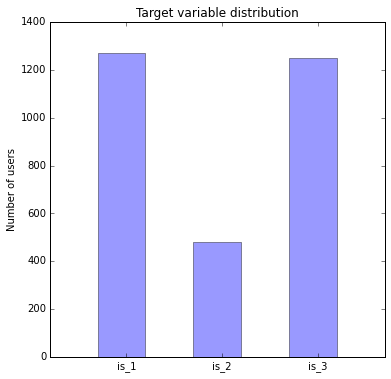

In [66]:
# Compute the distribution of the target variable

counts = [sum(df_users["is_1"]), sum(df_users["is_2"]), sum(df_users["is_3"])]
bins = [0, 1, 2]
print counts

# Plot the distribution
plt.figure(figsize=(6,6))
plt.bar(bins, counts, width=0.5, alpha=0.4)
plt.xticks([b + 0.3 for b in bins], ["is_1", "is_2", "is_3"])
plt.xlim(bins[0] - 0.5, bins[-1] + 1)
plt.ylabel("Number of users")
plt.title("Target variable distribution")
plt.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что user_id для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [67]:
CONSUMER_KEY = "wTOj2975uKAhyIyJkrjod2wju"
CONSUMER_SECRET = "v0IpKZ6LxnUN0DgGGAmLE7tgzjiK6u5zMYZnSIFX5ghN8hUoTp"

ACCESS_TOKEN_KEY = "272608335-xS7I2zHOzMQHaI2eSO3RTsPVi8XwOOajXsMxLW1P"
ACCESS_TOKEN_SECRET = "04aF4bmEktxhNv6jpi5QOESYIdLALUAiSmLJgs4h66q6H"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя. Кроме того, количество запросов ограничено 30к в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию `get_coordinates_by_location`, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [68]:
# Input your user name
GEO_USER_NAME = "kopbob"

def get_coordinates_by_location(location):
    """
    This function gets geographic coordinates and city name
    form external web service GeoNames using 'location' string.
    
    NOTE: the returned value is FAKE. It's only used to show
    NOTE: correct output format.
    http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
    """
    # your code here
    payload = {'q': location, 'username': GEO_USER_NAME, 'maxRows': 1}
    search_results = requests.get("http://api.geonames.org/searchJSON",
                                  params=payload).json()

    geonames = search_results.get('geonames')
    if not geonames:
        return False, (None, None, None)
    
    top_related = geonames[0]
    return True, (float(top_related['lat']),
                  float(top_related['lng']),
                  top_related['name'])

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (5 баллов).

In [69]:
import pickle

CHUNK_SIZE = 100
RAW_USERS_PKL_NAME = 'files/raw_users.pkl'

def download_twitter_users(df):
    twitter_users = []
    
    # try to open pre-downloaded json
    try:
        print "Reading Raw Users from %s ..." % RAW_USERS_PKL_NAME
        with open(RAW_USERS_PKL_NAME, 'rb') as infile:    
            twitter_users = pickle.load(infile)

    # if no pre-downloaded, download from api and save locally
    except IOError, ValueError:
        print("Starting download users by chunks of size 100:")
        sys.stdout.write('Chunks: ')

        num_of_chunks = int(math.ceil(df.twitter_id.count() / float(CHUNK_SIZE)))
        for x in range(num_of_chunks):
            idx_from = x*CHUNK_SIZE
            idx_to = (x + 1)*CHUNK_SIZE
            
            ids = df.twitter_id[idx_from:idx_to].tolist()
            users = api.UsersLookup(users=[twitter.User(id=i) for i in ids])
            
            twitter_users += users

            sys.stdout.write("%s(%s) " % (len(users), len(ids)))
        sys.stdout.write('\n%s of %s users are downloaded.\n' % (len(twitter_users), df.twitter_id.count()))

        with open(RAW_USERS_PKL_NAME, 'wb') as outfile:
            print "Dumping Raw Users to %s ..." % RAW_USERS_PKL_NAME
            pickle.dump(twitter_users, outfile)
            
    return twitter_users

In [70]:
import sys
import string
import re
import csv
import json

PREPARED_USERS_JSON_NAME = 'files/prepared_users.json'
ERRONEOUS_LOCATIONS_CSV_NAME = 'files/erroneous_locations.csv'

rx_not_ascii_lowercase = '[^' + re.escape(''.join(list(string.ascii_lowercase) + [' '])) + ']'
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None


def twitter_user_to_dataframe_record(user, index, loc_err_writer):
    record = {
        "twitter_id": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": user.created_at,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    # 1. Remove external symbols
    origin_location_str = unicode(user.location).encode("utf-8")
    user.location = re.sub(rx_not_ascii_lowercase, ' ', user.location.lower())
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        sys.stdout.write('\r%s' % index)
        
        # 2. Get geoinformation by api
        success, values = get_coordinates_by_location(user.location)
        record["lat"], record["lon"], record["country"] = values

        if not success:
            loc_err_writer.writerow([index, origin_location_str, unicode(user.location).encode("utf-8")])
    
    return record

def get_user_records(df):
    try:
        with open(PREPARED_USERS_JSON_NAME, 'r') as user_records_infile:    
            print "Reading Prepared Users from %s ..." % USER_RECORDS_JSON
            records = json.load(user_records_infile)

    except (IOError) as e:
        # 1. Downloading Users from api
        twitter_users = download_twitter_users(df)

        print "Getting coordinates and dumping erroneous to %s ..." % ERRONEOUS_LOCATIONS_CSV_NAME
        with open(ERRONEOUS_LOCATIONS_CSV_NAME, 'wb') as csvfile:
            loc_err_writer = csv.writer(csvfile, delimiter=',',
                                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
            loc_err_writer.writerow(['user_id', 'origin', 'replaced'])

            # 2. Users to dataframe records
            records = map(
                lambda (i, user): twitter_user_to_dataframe_record(user, i, loc_err_writer),
                enumerate(twitter_users)
            )
        sys.stdout.write('\n')
        
        with open(PREPARED_USERS_JSON_NAME, 'w') as outfile:
            print "Dumping Prepared Users to %s ..." % USER_RECORDS_JSON
            json.dump(records, outfile)

    return records


# Maximum number of user IDs returned by Twitter's user lookup

user_records = get_user_records(df_users)
        


here
Reading Prepared Users from prepared_user_records.json ...


In [71]:
# For erroneous lactions exploration
df_err_location = pd.read_csv(ERRONEOUS_LOCATIONS_CSV_NAME,
                              sep=",",
                              quotechar='|',
                              quoting=csv.QUOTE_MINIMAL)
df_err_location.count()

user_id     750
origin      750
replaced    750
dtype: int64

In [96]:
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["twitter_id", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="twitter_id", how="left")
df_full.created_at = df_full.created_at.apply(ts_parser)
# Remove Null rows
df_full = df_full[df_full.name.notnull()]
print "Finished building data frame"

Creating data frame from loaded data
Merging data frame with the training set
Finished building data frame


## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю пользователей каждого класса в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю пользователей класса ([подсказка](http://anokhin.github.io/img/hw1_distr.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (2 балла).

In [126]:
df_full = df_full.sort('created_at')

101 101 101 101 101


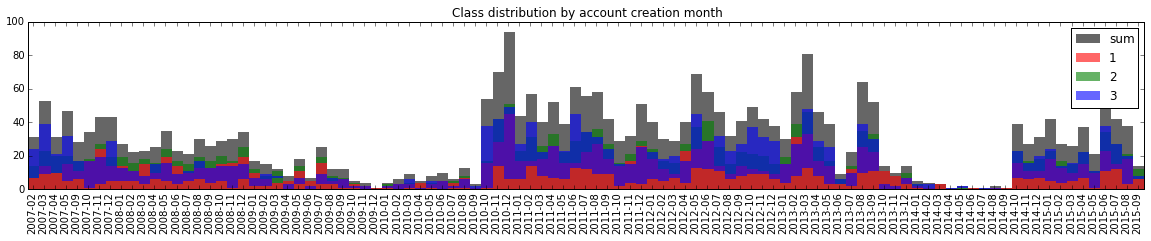

In [175]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_1 -- 1D numpy array with the counts of is_1 users created at each date
        count_2 -- 1D numpy array with the counts of is_2 users created at each date
        count_3 -- 1D numpy array with the counts of is_3 users created at each date
        dts -- a list of date strings, e.g. ['2014-10-11', '2014-10-12', ...]
    """
    dts = grouped.groups.keys()
    count_u = grouped['name'].count().as_matrix()
    
    count_1 = grouped.is_1.sum().as_matrix()
    count_2 = grouped.is_2.sum().as_matrix()
    count_3 = grouped.is_3.sum().as_matrix()
    print len(count_u), len(count_1), len(count_2), len(count_3), len(dts)
    return count_u, count_1, count_2, count_3, dts


grouped = df_full.groupby(map(lambda dt: dt.strftime("%Y-%m") if pd.notnull(dt) else "NA", df_full["created_at"]))
count_u, count_1, count_2, count_3, dts = count_users(grouped)
    
total = (count_1 + count_2 + count_3 + 1e-10)
fraction_1 = count_1 #/ total
fraction_2 = count_2 #/ total
fraction_3 = count_3 #/ total

sort_ind = np.argsort(dts)
    
plt.figure(figsize=(20, 3))
plt.bar(np.arange(len(dts)), count_u[sort_ind], width=1.0, color='black', alpha=0.6, linewidth=0, label="sum")
plt.bar(np.arange(len(dts)), fraction_1[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="1")
plt.bar(np.arange(len(dts)), fraction_2[sort_ind], bottom=fraction_1[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="2")
plt.bar(np.arange(len(dts)), fraction_3[sort_ind], bottom=fraction_2[sort_ind], width=1.0, color='blue', alpha=0.6, linewidth=0, label="3")

plt.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
plt.title("Class distribution by account creation month")
plt.xlim(0, len(dts))
plt.ylim(0, 100)
plt.legend()
plt.show()

Посмотрим, где живут пользователи каждой категории. Для этого отметим на карте каждого пользователя первого класса красным, второго - зеленым, третьего - синим цветом ([подсказка](http://anokhin.github.io/img/hw1_map.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (3 балла).

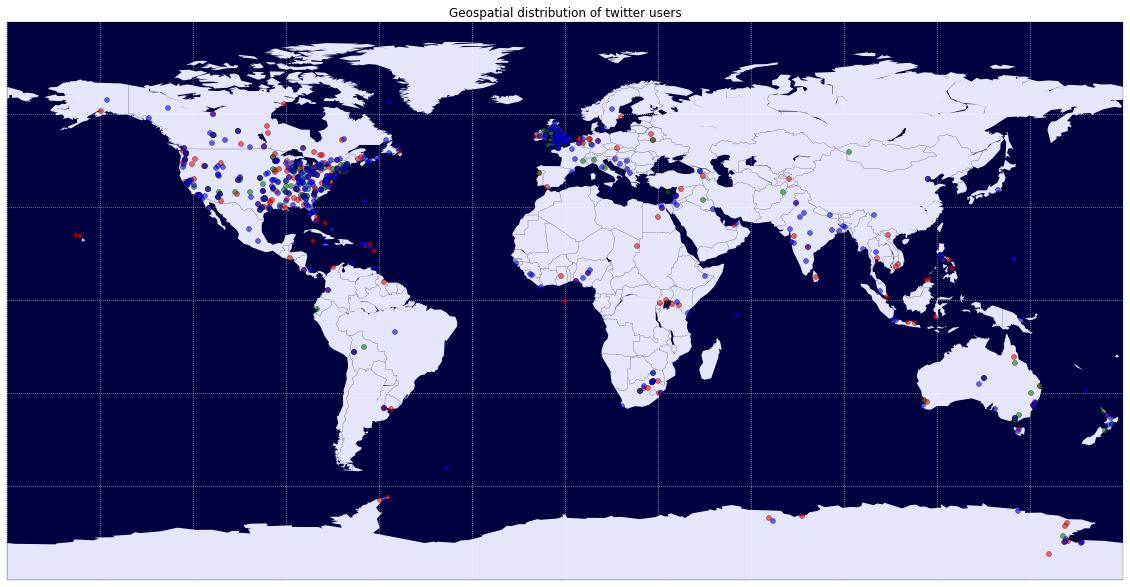

In [203]:
plt.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)


def plot_dots(lons, lats, color):
    x,y = m(lons, lats)
    m.plot(x, y, 'bo', markersize=5, color=color, alpha=0.6)

    
def plot_points_for_class(class_df, class_color='r'):
    # 1. remove repeated coordinates by making
    # set of all (lat,lot) pairs
    # Attention: Coordinates are reversed (lat is lon, lon is lat)
    #            because of my bug in get_coordinates_by_location.
    #            Now bug is fixed, but I can't rebuild notebook in a
    #            result of my api calls expiration.
    set_of_coordinates = set(zip(class_df.lat.tolist(),
                                 class_df.lon.tolist()))
    lats, lons = zip(*set_of_coordinates)
    plot_dots(lons=lats, lats=lons, color=class_color)
    

def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """
    plot_points_for_class(df_full[df_full.is_1 == 1], class_color='r')
    plot_points_for_class(df_full[df_full.is_2 == 1], class_color='g')
    plot_points_for_class(df_full[df_full.is_3 == 1], class_color='b')
    return

plot_points_on_map(df_full)

plt.title("Geospatial distribution of twitter users")
plt.legend()
plt.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой.

Смотрим на полученный data frame и сохраняем его в .csv файл.

In [204]:
OUT_FILE_PATH = "files/hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to files/hw1_out.csv


,twitter_id,is_1,is_2,is_3,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count,dts
1961,775637,1,0,0,Ken Bolton,kenbolton,Adventurer and Programmer,False,beacon,160.80000,-77.81667,West Beacon,2007-02-16 15:01:25+00:00,116,69,154,1,4,2007-2-16
2016,2182641,1,0,0,Steven Johnson,stevenbjohnson,Author. (Nine books.) Now TV host. (How We Got...,True,brooklyn ny marin county ca,NaN,NaN,None,2007-03-25 15:42:05+00:00,1391142,227,4362,20,5694,2007-3-25
258,2495181,0,0,1,craig sheldon,shoddyrobot,Design Director at http://t.co/JAN3b0HkN6. Opt...,False,atlanta ga,-84.38798,33.74900,Atlanta,2007-03-27 14:07:53+00:00,157,181,584,220,4,2007-3-27
2288,5520482,0,0,1,Jason Sheldon,ll0l00,NaN,False,san francisco,-84.12934,9.99299,San Francisco,2007-04-26 06:56:08+00:00,257,65,312,5,5,2007-4-26
2745,5530002,0,1,0,Jim Matthews,fetchguy,Author of the original Mac FTP client.,False,hanover nh,-72.28954,43.70229,Hanover,2007-04-26 15:04:58+00:00,329,238,1546,209,26,2007-4-26
